## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
import pytz as tz
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


In [2]:
# Ignore the warnings
warnings.simplefilter('ignore')

## Load training and prediction window data from saved sql databases

In [3]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [4]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-01-10,339.33,4.2,Japan,33.299778,135.513876,69.870000,85.812667,81.231429,4.354545,4.313333,4.357143,1
1,2022-01-10,84.74,4.3,Japan,33.299778,135.513876,73.267273,87.372000,87.670000,4.340909,4.300000,4.271429,1
2,2022-01-11,46.28,4.4,Japan,33.299778,135.513876,74.916364,86.615333,86.447143,4.322727,4.300000,4.314286,1
3,2022-01-11,34.49,4.6,Japan,33.299778,135.513876,71.993182,87.402667,86.284286,4.331818,4.320000,4.342857,1
4,2022-01-11,380.35,4.2,Japan,33.299778,135.513876,87.038636,111.248000,139.191429,4.327273,4.300000,4.342857,1


In [5]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [6]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2022-11-27,49.711,4.6,Japan,33.299778,135.513876,83.077636,89.482467,121.229286,4.540909,4.460000,4.600000,NaN
1,2022-11-29,10.000,5.0,Japan,33.299778,135.513876,83.077636,89.482467,113.889571,4.568182,4.513333,4.671429,NaN
2,2022-11-29,55.283,4.4,Japan,33.299778,135.513876,84.939636,92.501333,86.317857,4.527273,4.520000,4.614286,NaN
3,2022-11-30,53.289,5.0,Japan,33.299778,135.513876,85.541909,95.401533,90.851571,4.563636,4.586667,4.585714,NaN
4,2022-11-30,10.000,4.6,Japan,33.299778,135.513876,69.749136,91.681733,80.573429,4.495455,4.546667,4.642857,NaN


**Training is done by considering 22,15 & 7 days window past features rolling average and outcome data is shifted to next 7 Days.**

In [7]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

## Machine Learning & Boosting algorithms

### Decision Tree with Ada Boost Classifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [10]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [11]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [12]:
pred_ABC=grid_search_ABC.predict(X_test)

0.9089006038701254
AUC: 0.9089


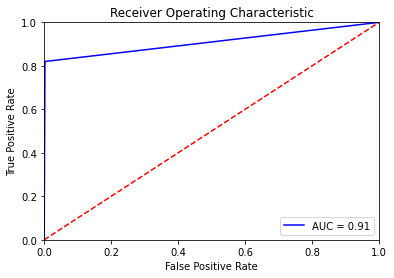

In [13]:

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[32410    72]
 [  606  2761]]
Confusion Matrix 
 [[32410   606]
 [   72  2761]]

Recall TP/TP+FN =  0.82001782001782


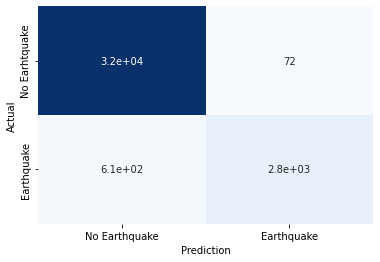

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_ABC))
print('Confusion Matrix \n',confusion_matrix(pred_ABC,y_test))
confusion_matrix= confusion_matrix(y_test,pred_ABC)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'], 
                 cbar=False, cmap='Blues')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
dtc=recall_score(y_test,pred_ABC)
print("\nRecall TP/TP+FN = ",dtc)

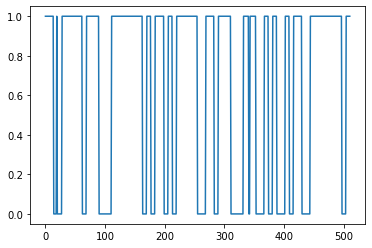

In [15]:
pred_ABC=grid_search_ABC.predict(df_predict[features])
plt.plot(pred_ABC)
plt.show()

In [16]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_ABC
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='days')

live_set

,date,place,latitude,longitude,quake
0,2022-03-27,Haiti,18.630986,-73.595337,1.0
1,2022-03-30,Haiti,18.630986,-73.595337,1.0
2,2022-04-06,Haiti,18.630986,-73.595337,1.0
3,2022-04-15,Haiti,18.630986,-73.595337,1.0
4,2022-04-29,Haiti,18.630986,-73.595337,1.0
...,...,...,...,...,...
366,2022-12-08,Japan,33.299778,135.513876,1.0
367,2022-12-08,New Zealand,-33.654791,-61.980008,1.0
368,2022-12-08,Philippines,10.520730,123.935076,1.0
369,2022-12-08,Puerto Rico,18.059253,-66.850617,0.0


In [18]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()
days
#Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-02'

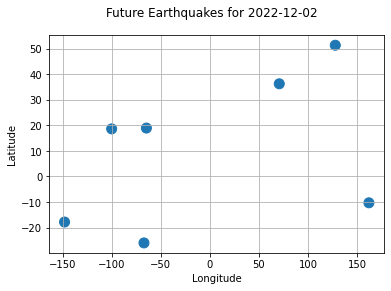

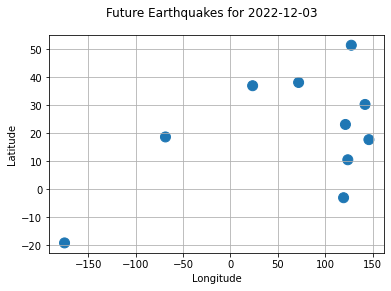

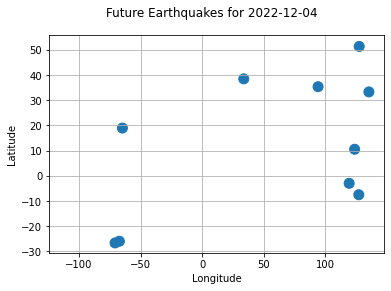

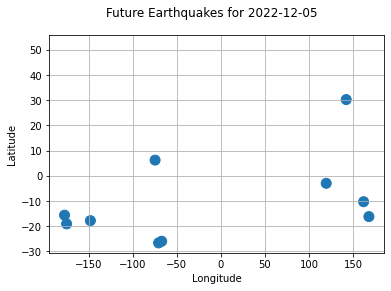

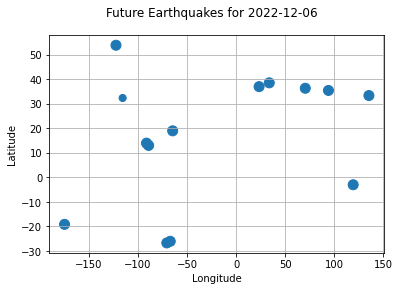

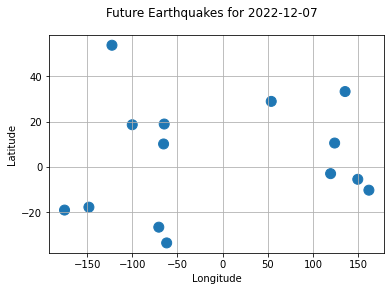

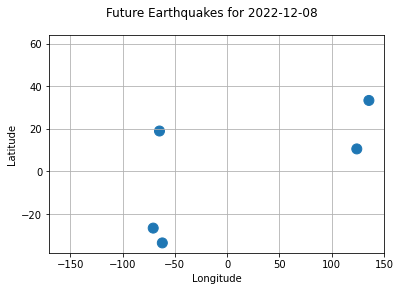

In [19]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [20]:
live_set.to_csv('dt_live_dataset.csv',index=False)

### Random Forest Classifier

In [21]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [22]:
pred=CV_rfc.predict(X_test)

0.9113082931659374
AUC: 0.9113


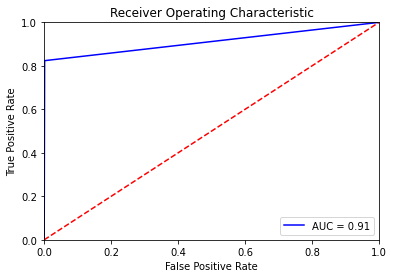

In [23]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[32441    41]
 [  593  2774]]
Confusion Matrix 
 [[32441   593]
 [   41  2774]]

Recall 'TP/TP+FN' =  0.8238788238788238


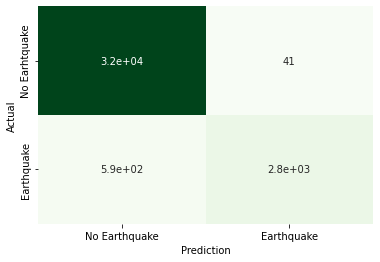

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred))
print('Confusion Matrix \n',confusion_matrix(pred,y_test))
confusion_matrix= confusion_matrix(y_test,pred)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Greens')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
rfc=recall_score(y_test,pred)
print("\nRecall 'TP/TP+FN' = ", rfc)

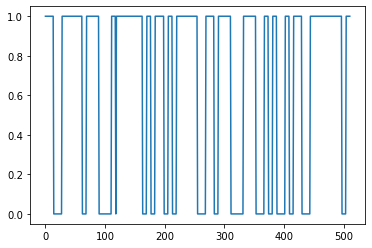

In [25]:
pred=CV_rfc.predict(df_predict[features])
plt.plot(pred)
plt.show()

In [26]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')
live_set.tail()

,date,place,latitude,longitude,quake
366,2022-12-08,Japan,33.299778,135.513876,1.0
367,2022-12-08,New Zealand,-33.654791,-61.980008,1.0
368,2022-12-08,Philippines,10.520730,123.935076,1.0
369,2022-12-08,Puerto Rico,18.059253,-66.850617,0.0
370,2022-12-08,U.S. Virgin Islands,18.932836,-64.701673,1.0


In [27]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-02'

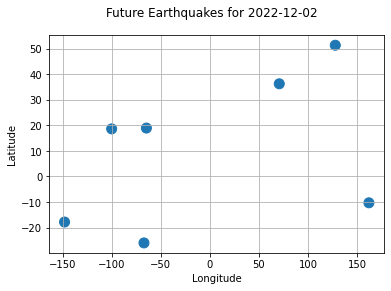

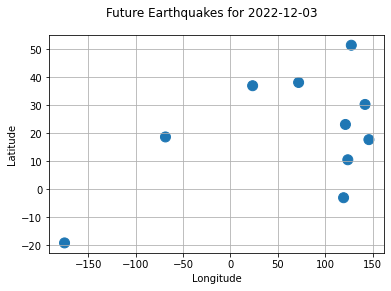

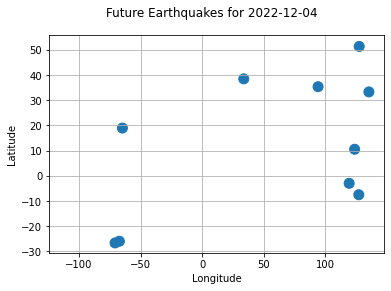

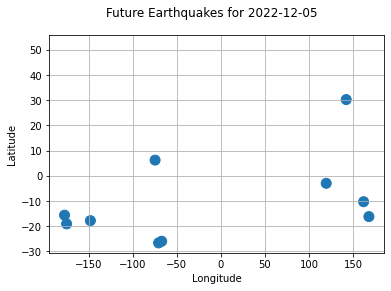

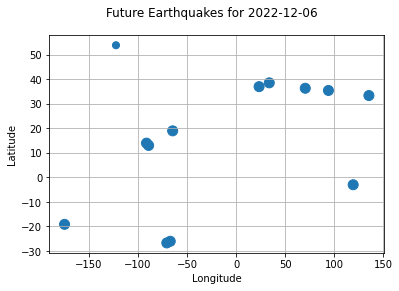

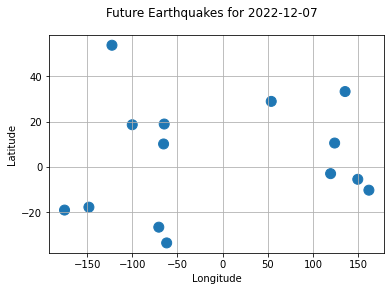

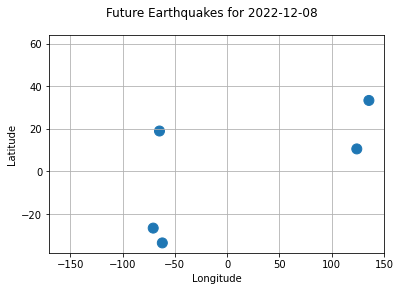

In [28]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [29]:
live_set.to_csv('rfc_live_dataset.csv',index=False)

### XGBoost Algorithm

In [30]:
from xgboost import XGBClassifier
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)


[09:35:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [31]:
ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

0.9911287551057271
AUC: 0.9911


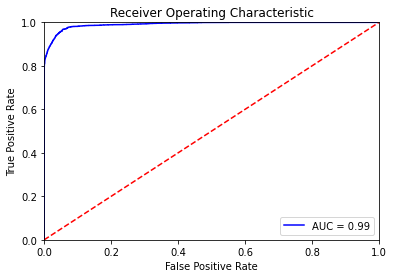

In [32]:

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Confusion Matrix 
 [[32444    38]
 [  631  2736]]
Confusion Matrix 
 [[32444   631]
 [   38  2736]]

Recall 'TP/TP+FN' =  0.8125928125928126


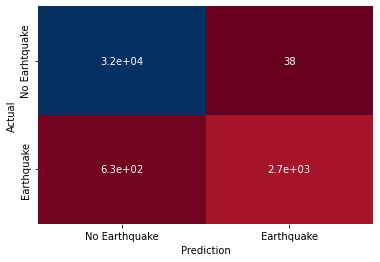

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,ypred_bst))
print('Confusion Matrix \n',confusion_matrix(ypred_bst,y_test))
confusion_matrix= confusion_matrix(y_test,ypred_bst)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='RdBu')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
xgbc=recall_score(y_test,ypred_bst)
print("\nRecall 'TP/TP+FN' = ", xgbc)

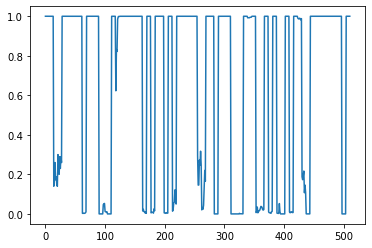

In [34]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [35]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
366,2022-12-08,Japan,33.299778,135.513876,0.999870
367,2022-12-08,New Zealand,-33.654791,-61.980008,0.999807
368,2022-12-08,Philippines,10.520730,123.935076,0.999830
369,2022-12-08,Puerto Rico,18.059253,-66.850617,0.259874
370,2022-12-08,U.S. Virgin Islands,18.932836,-64.701673,0.988017


In [36]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-02'

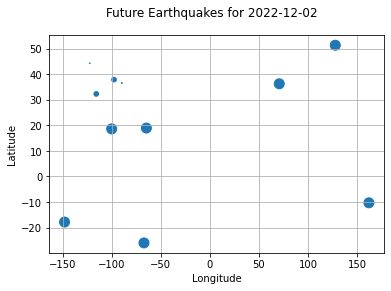

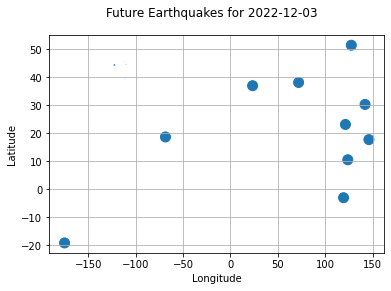

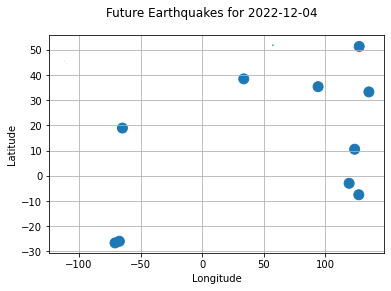

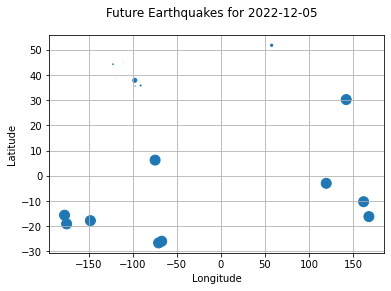

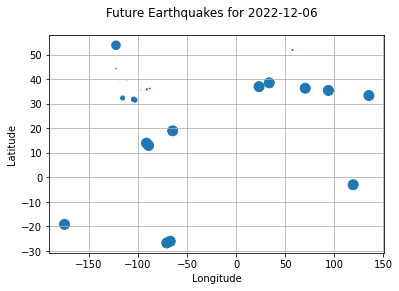

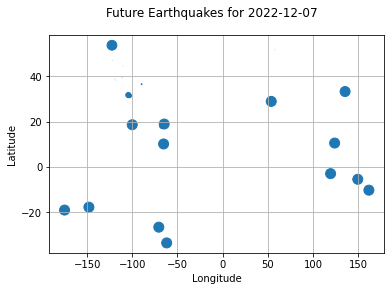

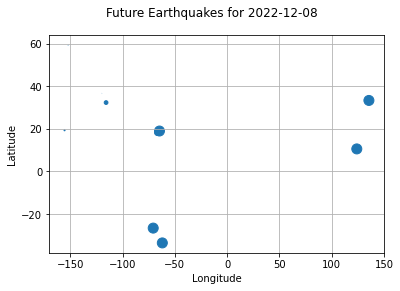

In [37]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [38]:
live_set.to_csv('xgb_live_dataset.csv',index=False)

### Multi-Layer Precepton

In [39]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# Input layer
model.add(Dense(128, activation='relu', input_dim=len(features)))
# Hidden Layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
# Output Layer
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
#Train the model
model.fit(X_train,y_train,epochs=500,verbose=False);

In [41]:
pred_mlp=(model.predict(X_test) > 0.5).astype("int32")

ROC_AUC_Score:  0.9012465006092245
AUC:  0.9012


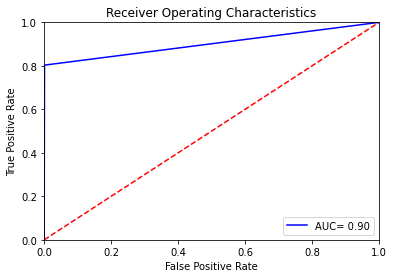

In [42]:
print("ROC_AUC_Score: ",roc_auc_score(y_test,pred_mlp))
fpr,tpr,_= roc_curve(y_test,pred_mlp)
roc_auc=auc(fpr,tpr)
print('AUC: ',np.round(roc_auc,4))

plt.title('Receiver Operating Characteristics')
plt.plot(fpr,tpr,'b',label='AUC= %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix 
 [[32453    29]
 [  662  2705]]
Confusion Matrix 
 [[32453   662]
 [   29  2705]]

Recall TP/TP+FN =  0.8033858033858033


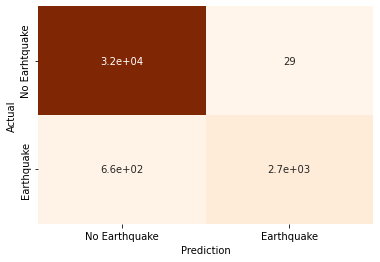

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print('Confusion Matrix \n',confusion_matrix(y_test,pred_mlp))
print('Confusion Matrix \n',confusion_matrix(pred_mlp,y_test))
confusion_matrix= confusion_matrix(y_test,pred_mlp)
hm = sns.heatmap(confusion_matrix, annot=True, xticklabels=['No Earthquake', 'Earthquake'], 
                 yticklabels=['No Earhtquake', 'Earthquake'],
                 cbar=False, cmap='Oranges')
hm.set_xlabel("Prediction")
hm.set_ylabel("Actual")
hm
mlpc=recall_score(y_test,pred_mlp)
print("\nRecall TP/TP+FN = ",mlpc)

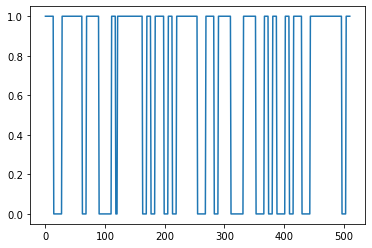

In [44]:
pred_mlp=(model.predict(df_predict[features]) > 0.5).astype("int32")
plt.plot(pred_mlp)
plt.show()

In [45]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = pred_mlp
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT 
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
366,2022-12-08,Japan,33.299778,135.513876,1.0
367,2022-12-08,New Zealand,-33.654791,-61.980008,1.0
368,2022-12-08,Philippines,10.520730,123.935076,1.0
369,2022-12-08,Puerto Rico,18.059253,-66.850617,0.0
370,2022-12-08,U.S. Virgin Islands,18.932836,-64.701673,1.0


In [46]:
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2022-12-02'

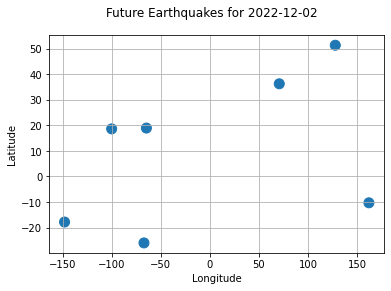

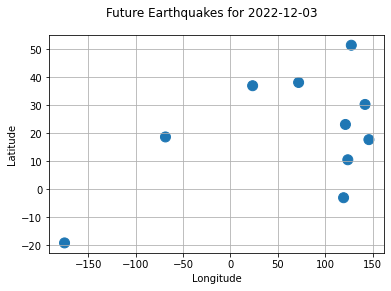

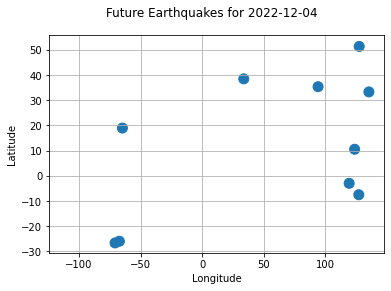

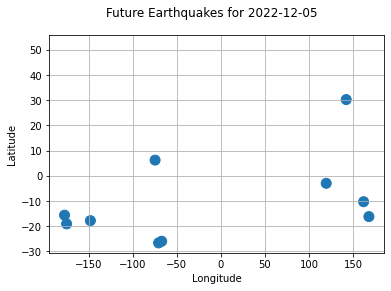

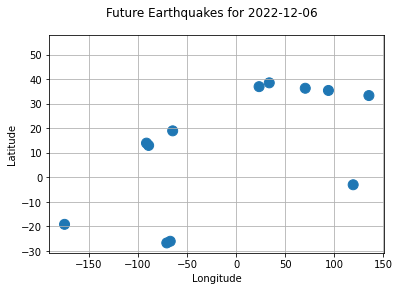

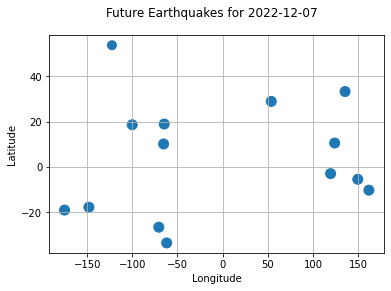

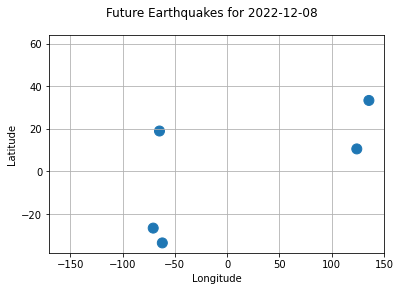

In [47]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()


In [48]:
live_set.to_csv('mlp_live_dataset.csv',index=False)

## Comparing models and find the best outcome

In [49]:

best_recall=max([dtc,rfc,xgbc,mlpc])
print("Recall (Sensitivity): ",best_recall)

Recall (Sensitivity):  0.8238788238788238


In [50]:
import datetime as dt
def live_prediction(x):
    if x== dtc:
        pred=grid_search_ABC.predict(df_predict[features])
    elif x==rfc:
        pred=CV_rfc.predict(df_predict[features])
    elif x==xgbc:
        dlive = xgb.DMatrix(df_predict[features]) #, label=[])
        pred = bst.predict(dlive)
    elif x==mlpc:
        pred=(model.predict(df_predict[features]) > 0.5).astype("int32")
    plt.plot(pred)
    plt.show()
    
    live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
    live_set.loc[:,'quake'] = pred
    # aggregate down dups
    live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

    # increment date to include DAYS_OUT_TO_PREDICT
    live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
    live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

    live_set.tail()
    
   # convert date to proper format for prediction
    days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.now(tz.timezone('US/Central')).strftime('%Y-%m-%d')]))
    days.sort()

    # Predict NaN outcome value in earthquake for next day 1.
    predict_day=days[0]
    predict_day
    
    # place, date, lat and long with earthquake probability for next 7 days
    for i in range(0,7):
        live_set_tmp = live_set[live_set['date'] == days[i]]
        plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
        plt.suptitle('Future Earthquakes for ' + days[i])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid()
        plt.show()
    
    live_set.to_csv('best_recall_live_dataset.csv',index=False)

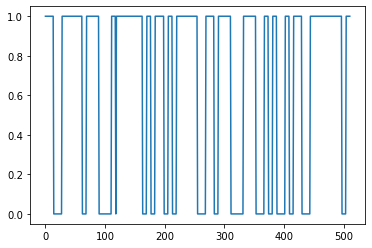

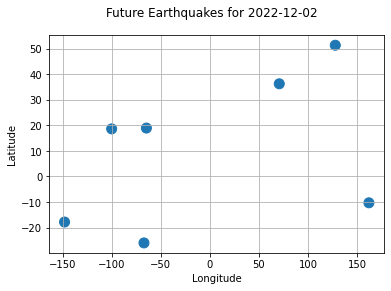

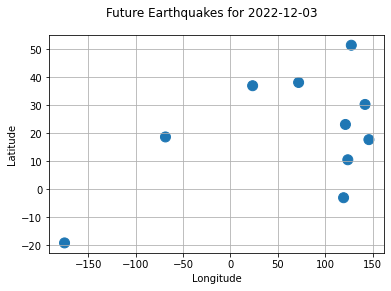

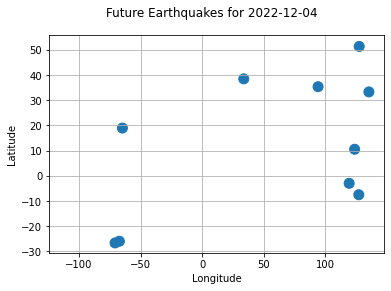

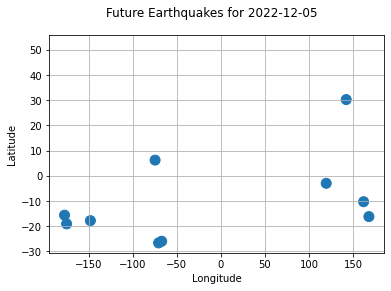

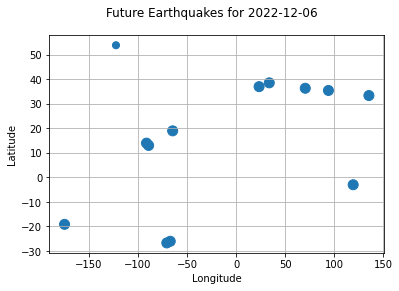

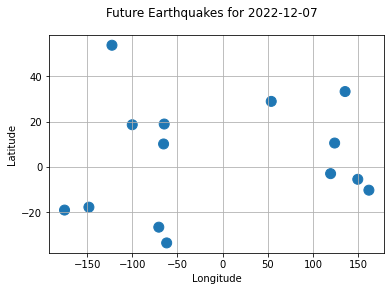

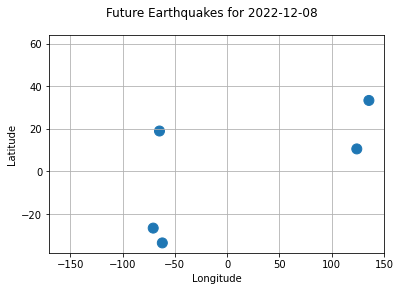

In [51]:
live_prediction(best_recall)